In [2]:
import rasterio
import pandas as pd

In [3]:
data = rasterio.open('../Data/Koppen-Geiger/koppen_geiger_0p00833333.tif')

climate_dict = {
    1: 'Af', 2: 'Am', 3: 'Aw', 4: 'BWh', 5: 'BWk', 6: 'BSh', 7: 'BSk', 8: 'Csa', 9: 'Csb', 10: 'Csc',
    11: 'Cwa', 12: 'Cwb', 13: 'Cwc', 14: 'Cfa', 15: 'Cfb', 16: 'Cfc', 17: 'Dsa', 18: 'Dsb', 19: 'Dsc',
    20: 'Dsd', 21: 'Dwa', 22: 'Dwb', 23: 'Dwc', 24: 'Dwd', 25: 'Dfa', 26: 'Dfb', 27: 'Dfc', 28: 'Dfd',
    29: 'ET', 30: 'EF'
}

z = data.read()[0]

print(data.crs)
print(data.bounds)

def getval(lon, lat):
    idx = data.index(lon, lat)
    return z[idx]

coordinates = pd.read_csv('../Data/long_lat.csv', sep='\t')

kg_data = [getval(lon, lat) for lon, lat in zip(coordinates['LONG'], coordinates['LAT'])]

coordinates['Koppen-Geiger'] = kg_data
coordinates['Koppen-Geiger-Name'] = coordinates['Koppen-Geiger'].map(climate_dict)
coordinates.to_csv('../Data/coords_with_koopen_geiger.csv', index=False)


EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)


In [4]:

unique_climates = coordinates['Koppen-Geiger-Name'].unique()
print(len(unique_climates))

15


In [5]:
coordinates = pd.read_csv('../Data/long_lat.csv', sep='\t')

min_lat = coordinates['LAT'].min()
max_lat = coordinates['LAT'].max()
min_long = coordinates['LONG'].min()
max_long = coordinates['LONG'].max()

print(f"Min Latitude: {min_lat}, Max Latitude: {max_lat}")
print(f"Min Longitude: {min_long}, Max Longitude: {max_long}")

unique_longs = coordinates['LONG'].unique()
unique_lats = coordinates['LAT'].unique()

print(f"Unique Longitudes: {len(unique_longs)}")
print(f"Unique Latitudes: {len(unique_lats)}")

unique_coordinates = coordinates.drop_duplicates(subset=['LONG', 'LAT'])[["LONG", "LAT"]]

Min Latitude: -9.0, Max Latitude: 68.8
Min Longitude: -123.206, Max Longitude: 136.31
Unique Longitudes: 748
Unique Latitudes: 683


In [6]:
size = 3.8
regions = []

coordinates = pd.read_csv('../Data/long_lat.csv', sep='\t')

unique_longs = coordinates['LONG'].unique()

sorted_longs = sorted(unique_longs)

current_long = sorted_longs[0]

max_long = sorted_longs[-1]

while current_long < max_long:
    next_long = min(current_long + size, max_long)

    valid_coordinates = coordinates[(coordinates['LONG'] >= current_long) & (coordinates['LONG'] <= next_long)]

    unique_lats = valid_coordinates['LAT'].unique()
    sorted_lats = sorted(unique_lats)

    current_lat = sorted_lats[0]
    max_lat = sorted_lats[-1] + 0.0001

    while current_lat < max_lat:
        next_lat = min(current_lat + size, max_lat)

        actual_coordinates = valid_coordinates[(valid_coordinates['LAT'] >= current_lat) & (valid_coordinates['LAT'] <= next_lat)]

        actual_lat_min = actual_coordinates['LAT'].min()
        actual_lat_max = actual_coordinates['LAT'].max()
        actual_long_min = actual_coordinates['LONG'].min()
        actual_long_max = actual_coordinates['LONG'].max()

        valid_ids = actual_coordinates["FID"]

        regions.append({
            'min_long': actual_long_min - 0.1,
            'max_long': actual_long_max + 0.1,
            'min_lat': actual_lat_min - 0.1,
            'max_lat': actual_lat_max + 0.1,
            'ids': valid_ids.to_list()
        })

        sorted_lats = [lat for lat in sorted_lats if lat > next_lat]

        if len(sorted_lats) == 0:
            break
        current_lat = sorted_lats[0]

    sorted_longs = [lon for lon in sorted_longs if lon > next_long]

    if len(sorted_longs) == 0:
        break
    current_long = sorted_longs[0]

regions

[{'min_long': np.float64(-122.85499999999999),
  'max_long': np.float64(-122.655),
  'min_lat': np.float64(41.2599),
  'max_lat': np.float64(41.459900000000005),
  'ids': [7033]},
 {'min_long': np.float64(-123.306),
  'max_long': np.float64(-122.10000000000001),
  'min_lat': np.float64(46.9),
  'max_lat': np.float64(49.365500000000004),
  'ids': [7306, 7332, 7350, 7383]},
 {'min_long': np.float64(-119.44999999999999),
  'max_long': np.float64(-119.25),
  'min_lat': np.float64(37.35),
  'max_lat': np.float64(37.550000000000004),
  'ids': [7416]},
 {'min_long': np.float64(-92.39999999999999),
  'max_long': np.float64(-92.2),
  'min_lat': np.float64(38.199999999999996),
  'max_lat': np.float64(38.4),
  'ids': [6909]},
 {'min_long': np.float64(-87.835),
  'max_long': np.float64(-84.3639),
  'min_lat': np.float64(37.8169),
  'max_lat': np.float64(41.7862),
  'ids': [470,
   476,
   484,
   504,
   506,
   531,
   801,
   6814,
   6927,
   7514,
   7515,
   7717,
   7757,
   7767,
   8037,
 

In [7]:
import pickle

with open('../Data/sample_areas.pkl', 'wb+') as f:
    pickle.dump(regions, f)

In [8]:
from scipy.ndimage import distance_transform_edt

# test = rasterio.open(f'../Data/WorldClim/wc2.1_30s_bio_1.tif')#rasterio.open(f"D:\Masters\Data\SoilGrids\wv0033_5-15cm_mean\wv0033_5-15cm_mean_-123_-122_46_49.tif")


def getval(lon, lat, data):
    y = data.read()[0]
    idx = data.index(lon, lat)

    value = y[idx]
    if value == -3.4e+38:
        mask = y == -3.4e+38
        min_row = max(0, idx[0] - 1000)
        max_row = min(y.shape[0], idx[0] + 1000)
        min_col = max(0, idx[1] - 1000)
        max_col = min(y.shape[1], idx[1] + 1000)
        local_mask = mask[min_row:max_row, min_col:max_col]
        local_y = y[min_row:max_row, min_col:max_col]
        distances, indices = distance_transform_edt(local_mask, return_indices=True)
        closest_non_zero = local_y[tuple(indices[:, idx[0] - min_row, idx[1] - min_col])]
        closest_distance = distances[tuple(indices[:, idx[0] - min_row, idx[1] - min_col])]
        value = closest_non_zero
    return value

# getval(-122.8, 47)

In [9]:
def read_all_coordinates(coordinates, data):
    y = data.read()[0]

    def getval(lon, lat):
        idx = data.index(lon, lat)

        value = y[idx]
        if value == -3.4e+38:
            mask = y == -3.4e+38
            min_row = max(0, idx[0] - 100)
            max_row = min(y.shape[0], idx[0] + 100)
            min_col = max(0, idx[1] - 100)
            max_col = min(y.shape[1], idx[1] + 100)
            local_mask = mask[min_row:max_row, min_col:max_col]
            local_y = y[min_row:max_row, min_col:max_col]
            distances, indices = distance_transform_edt(local_mask, return_indices=True)
            closest_non_zero = local_y[tuple(indices[:, idx[0] - min_row, idx[1] - min_col])]
            closest_distance = distances[tuple(indices[:, idx[0] - min_row, idx[1] - min_col])]
            value = closest_non_zero
        return value
    
    return [getval(lon, lat) for lon, lat in coordinates]

In [10]:
data = rasterio.open(f'../Data/WorldClim/wc2.1_30s_bio_1.tif')
getval(14.3336, 55.5796, data)

np.float32(7.945833)

In [11]:
coordinates = pd.read_csv('../Data/long_lat.csv', sep='\t')
for marker in range(1, 20):
    print(f'Reading marker {marker}')
    data = rasterio.open(f'../Data/WorldClim/wc2.1_30s_bio_{marker}.tif')
    marker_data = read_all_coordinates(zip(coordinates['LONG'], coordinates['LAT']), data)
    coordinates[f'BIO{marker}'] = marker_data

coordinates.to_csv('../Data/coords_with_bioclim_30s_fixed.csv', index=False)

Reading marker 1


KeyboardInterrupt: 

In [12]:
from scipy.ndimage import distance_transform_edt

coordinates = pd.read_csv('../Data/long_lat.csv', sep='\t')

def getval(lon, lat, data, uncertainty=False):
    y = data.read()[0]
    idx = data.index(lon, lat)
    approximate = False
    distance = 0

    if uncertainty:
        mask_val = 32767
    else:
        mask_val = 0

    value = y[idx]
    if value == mask_val:
        mask = y == mask_val
        distances, indices = distance_transform_edt(mask, return_indices=True)
        closest_non_zero = y[tuple(indices[:, idx[0], idx[1]])]
        # print(f"Closest non-zero value: {closest_non_zero}")
        # print(f"Distance: {distances[idx[0], idx[1]]}")
        distance = distances[idx[0], idx[1]]
        if distance > 4:
            value = -3.4e+38
            print(f"Warning: Large distance ({distance}) for coordinate ({lon}, {lat})")
        else:
            value = closest_non_zero
        # approximate = True
    return value

In [13]:
import pickle
from tqdm import tqdm

values = ['clay', 'nitrogen', 'bdod', 'soc', 'wv0033', 'phh2o']

for value in values:
    for uncertainty in [True, False]:
        if uncertainty:
            ext = 'uncertainty'
        else:
            ext = 'mean'

        accession_image_map = (f"../Data/SoilGrids/{value}_5-15cm_{ext}/sample_image_map.pkl")
        with open(accession_image_map, 'rb') as f:
            image_map = pickle.load(f)

        column_name = f'{value}_{ext}'
        coordinates[column_name] = None

        for accession, image in tqdm(image_map):
            # print(f'Reading accession {accession}')
            coords = coordinates[coordinates['FID'] == int(accession)]
            data = rasterio.open(image)
            marker_data = getval(coords['LONG'], coords['LAT'], data, uncertainty)
            coordinates.loc[coordinates['FID'] == int(accession), column_name] = marker_data

  1%|          | 11/1135 [00:00<00:23, 48.46it/s]

Name: LONG, dtype: float64, 474    47.2413
Name: LAT, dtype: float64)


 10%|█         | 114/1135 [00:02<00:17, 58.51it/s]

Name: LONG, dtype: float64, 477    41.6639
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 478    41.6639
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 479    41.6639
Name: LAT, dtype: float64)


 11%|█         | 127/1135 [00:02<00:25, 39.40it/s]

Name: LONG, dtype: float64, 310    42.373
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 311    42.373
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 504    41.767
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 439   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 499   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 501   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 503   -9.0
Name: LAT, dtype: float64)


 21%|██        | 241/1135 [00:06<00:38, 23.36it/s]

Name: LONG, dtype: float64, 987    40.45
Name: LAT, dtype: float64)


 33%|███▎      | 370/1135 [00:10<00:33, 22.57it/s]

Name: LONG, dtype: float64, 460    49.4424
Name: LAT, dtype: float64)


 36%|███▌      | 411/1135 [00:11<00:19, 36.98it/s]

Name: LONG, dtype: float64, 1024    40.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 397    47.3239
Name: LAT, dtype: float64)


 38%|███▊      | 426/1135 [00:12<00:28, 24.74it/s]

Name: LONG, dtype: float64, 315    51.2167
Name: LAT, dtype: float64)


 38%|███▊      | 433/1135 [00:13<01:00, 11.56it/s]

Name: LONG, dtype: float64, 395    49.416
Name: LAT, dtype: float64)


 38%|███▊      | 435/1135 [00:13<01:10,  9.86it/s]

Name: LONG, dtype: float64, 436    52.1611
Name: LAT, dtype: float64)


 39%|███▊      | 437/1135 [00:14<01:22,  8.49it/s]

Name: LONG, dtype: float64, 475    52.08
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 484    52.0918
Name: LAT, dtype: float64)


 41%|████      | 464/1135 [00:15<00:44, 15.13it/s]

Name: LONG, dtype: float64, 396    49.8724
Name: LAT, dtype: float64)


 41%|████▏     | 469/1135 [00:16<00:53, 12.35it/s]

Name: LONG, dtype: float64, 411    50.1102
Name: LAT, dtype: float64)


 42%|████▏     | 475/1135 [00:16<01:20,  8.22it/s]

Name: LONG, dtype: float64, 440    50.001
Name: LAT, dtype: float64)


 43%|████▎     | 484/1135 [00:18<01:42,  6.37it/s]

Name: LONG, dtype: float64, 495    47.3667
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 496    47.3667
Name: LAT, dtype: float64)


 48%|████▊     | 549/1135 [00:23<00:56, 10.34it/s]

Name: LONG, dtype: float64, 329    51.5338
Name: LAT, dtype: float64)


 49%|████▉     | 557/1135 [00:24<00:58,  9.82it/s]

Name: LONG, dtype: float64, 428    50.95
Name: LAT, dtype: float64)


 50%|████▉     | 564/1135 [00:24<00:47, 11.90it/s]

Name: LONG, dtype: float64, 378    44.5041
Name: LAT, dtype: float64)


 55%|█████▍    | 621/1135 [00:26<00:18, 27.88it/s]

Name: LONG, dtype: float64, 471    52.6058
Name: LAT, dtype: float64)


 59%|█████▉    | 669/1135 [00:29<00:42, 11.07it/s]

Name: LONG, dtype: float64, 235    55.8411
Name: LAT, dtype: float64)


 61%|██████    | 689/1135 [00:31<00:42, 10.47it/s]

Name: LONG, dtype: float64, 420    55.675
Name: LAT, dtype: float64)


 78%|███████▊  | 881/1135 [00:37<00:05, 47.23it/s]

Name: LONG, dtype: float64, 642    56.5804
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1118    68.8
Name: LAT, dtype: float64)


 90%|████████▉ | 1016/1135 [00:38<00:01, 72.57it/s]

Name: LONG, dtype: float64, 882    47.16
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1130    60.4
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 339    55.7522
Name: LAT, dtype: float64)


 91%|█████████ | 1034/1135 [00:39<00:01, 50.83it/s]

Name: LONG, dtype: float64, 1122    61.59
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1123    61.59
Name: LAT, dtype: float64)


100%|██████████| 1135/1135 [00:40<00:00, 27.77it/s]


Name: LONG, dtype: float64, 431    35.0085
Name: LAT, dtype: float64)


  0%|          | 4/1135 [00:00<00:30, 37.40it/s]

Name: LONG, dtype: float64, 474    47.2413
Name: LAT, dtype: float64)


  9%|▉         | 104/1135 [00:02<00:23, 43.39it/s]

Name: LONG, dtype: float64, 477    41.6639
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 478    41.6639
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 479    41.6639
Name: LAT, dtype: float64)


 11%|█         | 125/1135 [00:03<00:35, 28.62it/s]

Name: LONG, dtype: float64, 310    42.373
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 311    42.373
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 504    41.767
Name: LAT, dtype: float64)


 12%|█▏        | 134/1135 [00:03<00:26, 37.67it/s]

Name: LONG, dtype: float64, 439   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 499   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 501   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 503   -9.0
Name: LAT, dtype: float64)


 21%|██        | 239/1135 [00:09<00:59, 15.09it/s]

Name: LONG, dtype: float64, 987    40.45
Name: LAT, dtype: float64)


 32%|███▏      | 368/1135 [00:13<00:37, 20.56it/s]

Name: LONG, dtype: float64, 460    49.4424
Name: LAT, dtype: float64)


 36%|███▌      | 410/1135 [00:15<00:24, 29.16it/s]

Name: LONG, dtype: float64, 1024    40.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 397    47.3239
Name: LAT, dtype: float64)


 38%|███▊      | 426/1135 [00:16<00:37, 18.89it/s]

Name: LONG, dtype: float64, 315    51.2167
Name: LAT, dtype: float64)


 38%|███▊      | 432/1135 [00:17<01:15,  9.36it/s]

Name: LONG, dtype: float64, 395    49.416
Name: LAT, dtype: float64)


 38%|███▊      | 434/1135 [00:17<01:26,  8.07it/s]

Name: LONG, dtype: float64, 436    52.1611
Name: LAT, dtype: float64)


 38%|███▊      | 436/1135 [00:17<01:36,  7.22it/s]

Name: LONG, dtype: float64, 475    52.08
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 484    52.0918
Name: LAT, dtype: float64)


 41%|████      | 462/1135 [00:19<00:36, 18.52it/s]

Name: LONG, dtype: float64, 396    49.8724
Name: LAT, dtype: float64)


 41%|████      | 468/1135 [00:20<01:04, 10.27it/s]

Name: LONG, dtype: float64, 411    50.1102
Name: LAT, dtype: float64)


 42%|████▏     | 474/1135 [00:21<01:42,  6.48it/s]

Name: LONG, dtype: float64, 440    50.001
Name: LAT, dtype: float64)


 43%|████▎     | 484/1135 [00:23<01:49,  5.93it/s]

Name: LONG, dtype: float64, 495    47.3667
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 496    47.3667
Name: LAT, dtype: float64)


 48%|████▊     | 548/1135 [00:29<01:16,  7.70it/s]

Name: LONG, dtype: float64, 329    51.5338
Name: LAT, dtype: float64)


 49%|████▉     | 557/1135 [00:30<01:10,  8.24it/s]

Name: LONG, dtype: float64, 428    50.95
Name: LAT, dtype: float64)


 50%|████▉     | 564/1135 [00:30<00:48, 11.82it/s]

Name: LONG, dtype: float64, 378    44.5041
Name: LAT, dtype: float64)


 55%|█████▌    | 626/1135 [00:32<00:22, 22.88it/s]

Name: LONG, dtype: float64, 471    52.6058
Name: LAT, dtype: float64)


 59%|█████▉    | 668/1135 [00:35<00:43, 10.65it/s]

Name: LONG, dtype: float64, 235    55.8411
Name: LAT, dtype: float64)


 61%|██████    | 689/1135 [00:37<00:34, 12.87it/s]

Name: LONG, dtype: float64, 420    55.675
Name: LAT, dtype: float64)


 77%|███████▋  | 878/1135 [00:41<00:04, 52.14it/s]

Name: LONG, dtype: float64, 642    56.5804
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1118    68.8
Name: LAT, dtype: float64)


 89%|████████▉ | 1013/1135 [00:43<00:01, 81.39it/s]

Name: LONG, dtype: float64, 882    47.16
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1130    60.4
Name: LAT, dtype: float64)


 90%|█████████ | 1024/1135 [00:43<00:01, 55.62it/s]

Name: LONG, dtype: float64, 339    55.7522
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1122    61.59
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1123    61.59
Name: LAT, dtype: float64)


100%|██████████| 1135/1135 [00:44<00:00, 25.25it/s] 


Name: LONG, dtype: float64, 431    35.0085
Name: LAT, dtype: float64)


  0%|          | 5/1135 [00:00<00:25, 44.83it/s]

Name: LONG, dtype: float64, 474    47.2413
Name: LAT, dtype: float64)


 10%|█         | 114/1135 [00:02<00:18, 56.62it/s]

Name: LONG, dtype: float64, 477    41.6639
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 478    41.6639
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 479    41.6639
Name: LAT, dtype: float64)


 11%|█         | 127/1135 [00:03<00:25, 38.84it/s]

Name: LONG, dtype: float64, 310    42.373
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 311    42.373
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 504    41.767
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 439   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 499   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 501   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 503   -9.0
Name: LAT, dtype: float64)


 18%|█▊        | 200/1135 [00:05<00:34, 27.40it/s]

Name: LONG, dtype: float64, 150    56.7333
Name: LAT, dtype: float64)


 21%|██        | 240/1135 [00:07<00:45, 19.74it/s]

Name: LONG, dtype: float64, 987    40.45
Name: LAT, dtype: float64)


 33%|███▎      | 369/1135 [00:12<00:40, 18.95it/s]

Name: LONG, dtype: float64, 460    49.4424
Name: LAT, dtype: float64)


 36%|███▌      | 411/1135 [00:13<00:23, 30.60it/s]

Name: LONG, dtype: float64, 1024    40.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 397    47.3239
Name: LAT, dtype: float64)


 37%|███▋      | 425/1135 [00:14<00:26, 27.02it/s]

Name: LONG, dtype: float64, 315    51.2167
Name: LAT, dtype: float64)


 38%|███▊      | 432/1135 [00:15<01:08, 10.29it/s]

Name: LONG, dtype: float64, 395    49.416
Name: LAT, dtype: float64)


 38%|███▊      | 434/1135 [00:16<01:21,  8.58it/s]

Name: LONG, dtype: float64, 436    52.1611
Name: LAT, dtype: float64)


 38%|███▊      | 436/1135 [00:16<01:33,  7.48it/s]

Name: LONG, dtype: float64, 475    52.08
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 484    52.0918
Name: LAT, dtype: float64)


 41%|████      | 465/1135 [00:18<01:01, 10.96it/s]

Name: LONG, dtype: float64, 396    49.8724
Name: LAT, dtype: float64)


 41%|████      | 468/1135 [00:18<01:00, 10.97it/s]

Name: LONG, dtype: float64, 411    50.1102
Name: LAT, dtype: float64)


 42%|████▏     | 474/1135 [00:19<01:38,  6.72it/s]

Name: LONG, dtype: float64, 440    50.001
Name: LAT, dtype: float64)


 43%|████▎     | 483/1135 [00:21<01:47,  6.08it/s]

Name: LONG, dtype: float64, 495    47.3667
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 496    47.3667
Name: LAT, dtype: float64)


 48%|████▊     | 548/1135 [00:27<01:11,  8.16it/s]

Name: LONG, dtype: float64, 329    51.5338
Name: LAT, dtype: float64)


 49%|████▉     | 557/1135 [00:28<01:06,  8.69it/s]

Name: LONG, dtype: float64, 428    50.95
Name: LAT, dtype: float64)


 50%|████▉     | 563/1135 [00:29<00:59,  9.57it/s]

Name: LONG, dtype: float64, 378    44.5041
Name: LAT, dtype: float64)


 55%|█████▌    | 626/1135 [00:31<00:25, 19.83it/s]

Name: LONG, dtype: float64, 471    52.6058
Name: LAT, dtype: float64)


 59%|█████▉    | 668/1135 [00:34<00:43, 10.69it/s]

Name: LONG, dtype: float64, 235    55.8411
Name: LAT, dtype: float64)


 61%|██████    | 689/1135 [00:35<00:35, 12.53it/s]

Name: LONG, dtype: float64, 420    55.675
Name: LAT, dtype: float64)


 78%|███████▊  | 880/1135 [00:41<00:05, 47.21it/s]

Name: LONG, dtype: float64, 642    56.5804
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1118    68.8
Name: LAT, dtype: float64)


 90%|████████▉ | 1018/1135 [00:43<00:01, 69.54it/s]

Name: LONG, dtype: float64, 882    47.16
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1130    60.4
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 339    55.7522
Name: LAT, dtype: float64)


 91%|█████████ | 1034/1135 [00:43<00:02, 46.61it/s]

Name: LONG, dtype: float64, 1122    61.59
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1123    61.59
Name: LAT, dtype: float64)


100%|██████████| 1135/1135 [00:45<00:00, 25.08it/s]


Name: LONG, dtype: float64, 431    35.0085
Name: LAT, dtype: float64)


  0%|          | 4/1135 [00:00<00:32, 34.48it/s]

Name: LONG, dtype: float64, 474    47.2413
Name: LAT, dtype: float64)


 10%|█         | 114/1135 [00:03<00:22, 46.35it/s]

Name: LONG, dtype: float64, 477    41.6639
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 478    41.6639
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 479    41.6639
Name: LAT, dtype: float64)


 11%|█         | 124/1135 [00:03<00:33, 30.39it/s]

Name: LONG, dtype: float64, 310    42.373
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 311    42.373
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 504    41.767
Name: LAT, dtype: float64)


 12%|█▏        | 131/1135 [00:03<00:26, 37.29it/s]

Name: LONG, dtype: float64, 439   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 499   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 501   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 503   -9.0
Name: LAT, dtype: float64)


 21%|██        | 239/1135 [00:08<00:52, 17.07it/s]

Name: LONG, dtype: float64, 987    40.45
Name: LAT, dtype: float64)


 32%|███▏      | 367/1135 [00:13<00:41, 18.66it/s]

Name: LONG, dtype: float64, 460    49.4424
Name: LAT, dtype: float64)


 36%|███▌      | 408/1135 [00:14<00:26, 27.70it/s]

Name: LONG, dtype: float64, 1024    40.0
Name: LAT, dtype: float64)


 36%|███▋      | 412/1135 [00:14<00:32, 21.97it/s]

Name: LONG, dtype: float64, 397    47.3239
Name: LAT, dtype: float64)


 38%|███▊      | 426/1135 [00:15<00:38, 18.56it/s]

Name: LONG, dtype: float64, 315    51.2167
Name: LAT, dtype: float64)


 38%|███▊      | 433/1135 [00:17<01:30,  7.73it/s]

Name: LONG, dtype: float64, 395    49.416
Name: LAT, dtype: float64)


 38%|███▊      | 435/1135 [00:17<01:43,  6.76it/s]

Name: LONG, dtype: float64, 436    52.1611
Name: LAT, dtype: float64)


 38%|███▊      | 436/1135 [00:17<01:48,  6.42it/s]

Name: LONG, dtype: float64, 475    52.08
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 484    52.0918
Name: LAT, dtype: float64)


 41%|████      | 465/1135 [00:19<01:06, 10.02it/s]

Name: LONG, dtype: float64, 396    49.8724
Name: LAT, dtype: float64)


 41%|████      | 468/1135 [00:20<01:05, 10.19it/s]

Name: LONG, dtype: float64, 411    50.1102
Name: LAT, dtype: float64)


 42%|████▏     | 474/1135 [00:21<01:45,  6.27it/s]

Name: LONG, dtype: float64, 440    50.001
Name: LAT, dtype: float64)


 43%|████▎     | 483/1135 [00:22<01:52,  5.81it/s]

Name: LONG, dtype: float64, 495    47.3667
Name: LAT, dtype: float64)


 43%|████▎     | 487/1135 [00:23<01:15,  8.61it/s]

Name: LONG, dtype: float64, 496    47.3667
Name: LAT, dtype: float64)


 49%|████▊     | 551/1135 [00:28<00:48, 12.16it/s]

Name: LONG, dtype: float64, 329    51.5338
Name: LAT, dtype: float64)


 49%|████▉     | 557/1135 [00:29<01:02,  9.25it/s]

Name: LONG, dtype: float64, 428    50.95
Name: LAT, dtype: float64)


 50%|████▉     | 564/1135 [00:30<00:49, 11.63it/s]

Name: LONG, dtype: float64, 378    44.5041
Name: LAT, dtype: float64)


 55%|█████▍    | 622/1135 [00:31<00:18, 27.07it/s]

Name: LONG, dtype: float64, 471    52.6058
Name: LAT, dtype: float64)


 59%|█████▉    | 668/1135 [00:34<00:45, 10.22it/s]

Name: LONG, dtype: float64, 235    55.8411
Name: LAT, dtype: float64)


 61%|██████    | 689/1135 [00:36<00:38, 11.54it/s]

Name: LONG, dtype: float64, 420    55.675
Name: LAT, dtype: float64)


 78%|███████▊  | 885/1135 [00:42<00:04, 60.23it/s]

Name: LONG, dtype: float64, 642    56.5804
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1118    68.8
Name: LAT, dtype: float64)


 90%|████████▉ | 1016/1135 [00:43<00:01, 80.69it/s]

Name: LONG, dtype: float64, 882    47.16
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1130    60.4
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 339    55.7522
Name: LAT, dtype: float64)


 91%|█████████ | 1035/1135 [00:44<00:01, 57.05it/s]

Name: LONG, dtype: float64, 1122    61.59
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 1123    61.59
Name: LAT, dtype: float64)


100%|██████████| 1135/1135 [00:45<00:00, 24.93it/s] 


Name: LONG, dtype: float64, 431    35.0085
Name: LAT, dtype: float64)


  0%|          | 5/1135 [00:00<00:24, 45.27it/s]

Name: LONG, dtype: float64, 474    47.2413
Name: LAT, dtype: float64)


 10%|█         | 114/1135 [00:02<00:15, 64.44it/s]

Name: LONG, dtype: float64, 477    41.6639
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 478    41.6639
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 479    41.6639
Name: LAT, dtype: float64)


 11%|█         | 127/1135 [00:02<00:23, 42.58it/s]

Name: LONG, dtype: float64, 310    42.373
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 311    42.373
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 504    41.767
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 439   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 499   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 501   -9.0
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 503   -9.0
Name: LAT, dtype: float64)


 21%|██        | 241/1135 [00:06<00:32, 27.80it/s]

Name: LONG, dtype: float64, 987    40.45
Name: LAT, dtype: float64)


 33%|███▎      | 369/1135 [00:09<00:29, 26.06it/s]

Name: LONG, dtype: float64, 460    49.4424
Name: LAT, dtype: float64)


 36%|███▌      | 406/1135 [00:10<00:20, 35.65it/s]

Name: LONG, dtype: float64, 1024    40.0
Name: LAT, dtype: float64)


 36%|███▋      | 412/1135 [00:10<00:23, 30.95it/s]

Name: LONG, dtype: float64, 397    47.3239
Name: LAT, dtype: float64)


 38%|███▊      | 426/1135 [00:11<00:26, 26.47it/s]

Name: LONG, dtype: float64, 315    51.2167
Name: LAT, dtype: float64)


 38%|███▊      | 432/1135 [00:12<00:54, 12.88it/s]

Name: LONG, dtype: float64, 395    49.416
Name: LAT, dtype: float64)


 38%|███▊      | 434/1135 [00:12<01:05, 10.78it/s]

Name: LONG, dtype: float64, 436    52.1611
Name: LAT, dtype: float64)


 38%|███▊      | 436/1135 [00:12<01:16,  9.17it/s]

Name: LONG, dtype: float64, 475    52.08
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 484    52.0918
Name: LAT, dtype: float64)


 41%|████      | 466/1135 [00:14<00:44, 15.15it/s]

Name: LONG, dtype: float64, 396    49.8724
Name: LAT, dtype: float64)


 41%|████▏     | 470/1135 [00:14<00:50, 13.11it/s]

Name: LONG, dtype: float64, 411    50.1102
Name: LAT, dtype: float64)


 42%|████▏     | 476/1135 [00:15<01:13,  8.95it/s]

Name: LONG, dtype: float64, 440    50.001
Name: LAT, dtype: float64)


 43%|████▎     | 484/1135 [00:16<01:26,  7.52it/s]

Name: LONG, dtype: float64, 495    47.3667
Name: LAT, dtype: float64)
Name: LONG, dtype: float64, 496    47.3667
Name: LAT, dtype: float64)


 48%|████▊     | 542/1135 [00:21<00:22, 25.80it/s]


KeyboardInterrupt: 

In [ ]:
print(f"Approximate values: {count_approx}")
print(f"Average distance: {sum(distances) / len(distances)}")
print(f"Max distance: {max(distances)}")
print(f"Median distance: {sorted(distances)[len(distances) // 2]}")
print(f"Distances over 4: {len([d for d in distances if d >= 4])}")

Approximate values: 263
Average distance: 4.923928401096923
Max distance: 353.73577709923546
Median distance: 2.0
Distances over 4: 41


In [ ]:
print(f"Approximate values: {count_approx}")
print(f"Average distance: {sum(distances) / len(distances)}")
print(f"Max distance: {max(distances)}")
print(f"Median distance: {sorted(distances)[len(distances) // 2]}")
print(f"Distances over 4: {len([d for d in distances if d > 4])}")

Approximate values: 265
Average distance: 4.89431384712638
Max distance: 353.73577709923546
Median distance: 2.0
Distances over 4: 39


In [14]:
# coordinates.to_csv('../Data/coords_with_soil.csv', index=False)

coordinates = pd.read_csv('../Data/coords_with_soil.csv')

In [15]:
invalid_accessions = coordinates[coordinates['clay_mean'] == -3.4e+38]
invalid_accessions_uncertainty = coordinates[coordinates['nitrogen_uncertainty'] == -3.4e+38]

# remove invalid accessions from the coordinates dataframe
coordinates = coordinates[~coordinates['FID'].isin(invalid_accessions_uncertainty['FID'])]

# Calculate the relative uncertainty for each column
values = ['clay', 'nitrogen', 'bdod', 'soc', 'wv0033', 'phh2o']
for value in values:
    coordinates.loc[:, f'{value}_relative_uncertainty'] = coordinates[f'{value}_uncertainty'] / coordinates[f'{value}_mean']

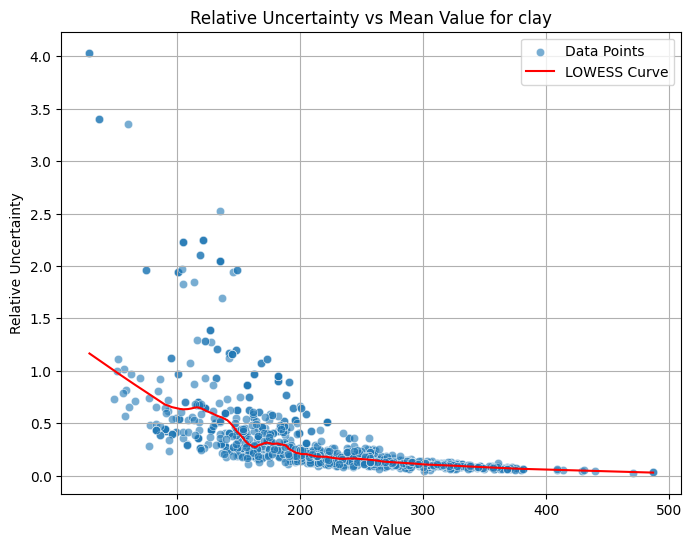

0.3359824572150679


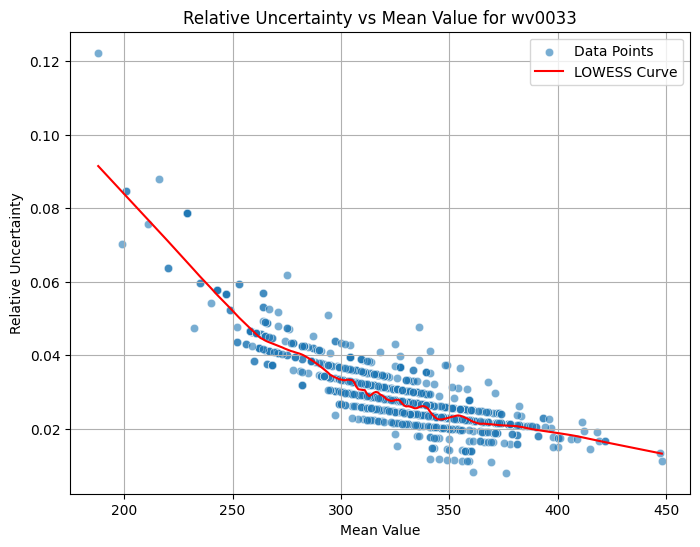

0.02983832673387446


In [21]:
# For each value, plot the distribution of relative uncertainty relative to the mean value
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_relative_uncertainty(df, value):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[f'{value}_mean'], y=df[f'{value}_relative_uncertainty'], alpha=0.6, label='Data Points')
    
    # Fit and plot a LOWESS (Locally Weighted Scatterplot Smoothing) curve
    lowess_curve = lowess(df[f'{value}_relative_uncertainty'], df[f'{value}_mean'], frac=0.1)
    plt.plot(lowess_curve[:, 0], lowess_curve[:, 1], color='red', label='LOWESS Curve')
    
    plt.title(f'Relative Uncertainty vs Mean Value for {value}')
    plt.xlabel('Mean Value')
    plt.ylabel('Relative Uncertainty')
    plt.legend()
    plt.grid(True)
    plt.show()

values = ['clay','wv0033']

for value in values:
    plot_relative_uncertainty(coordinates, value)
    print(coordinates[f'{value}_relative_uncertainty'].mean())


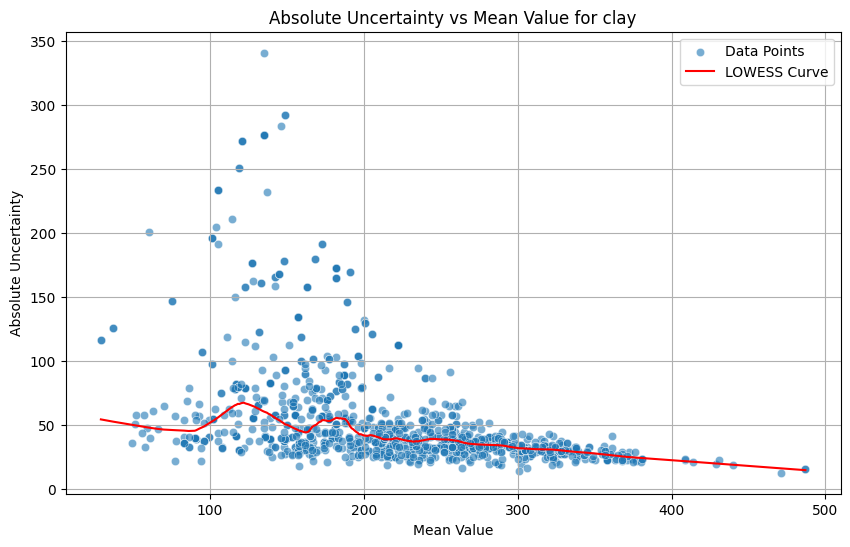

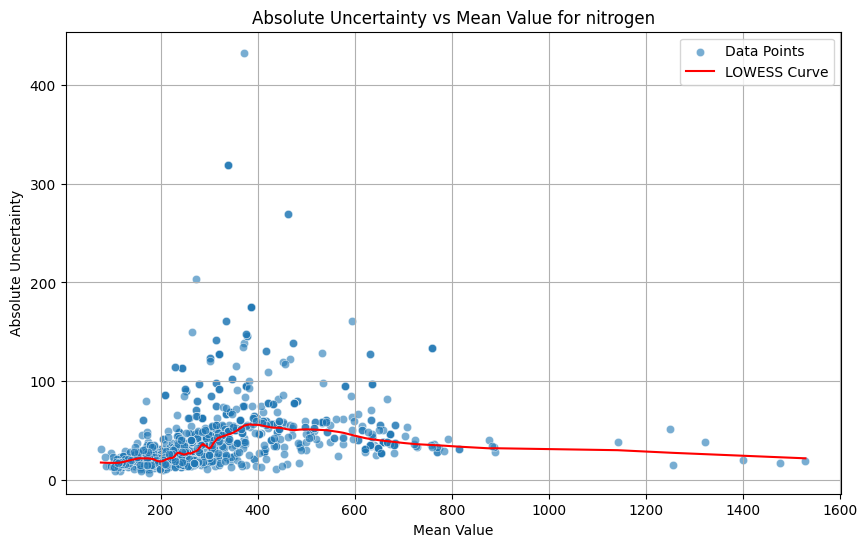

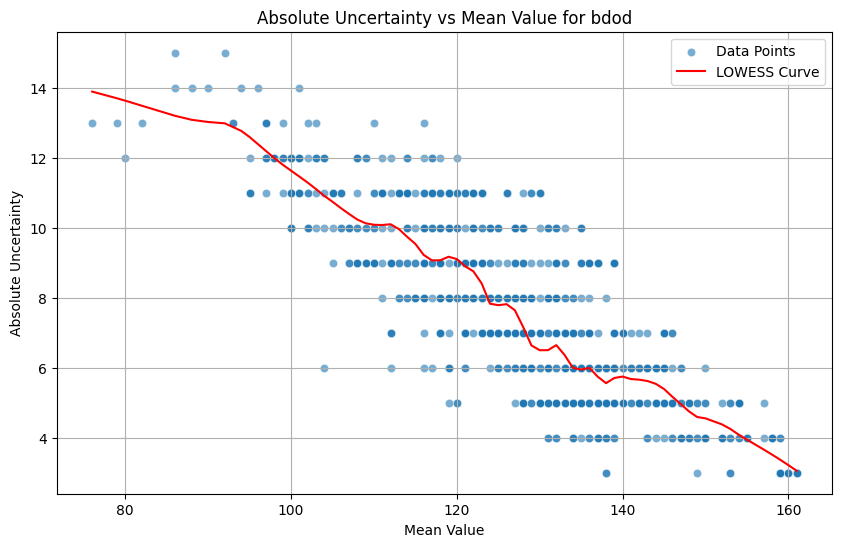

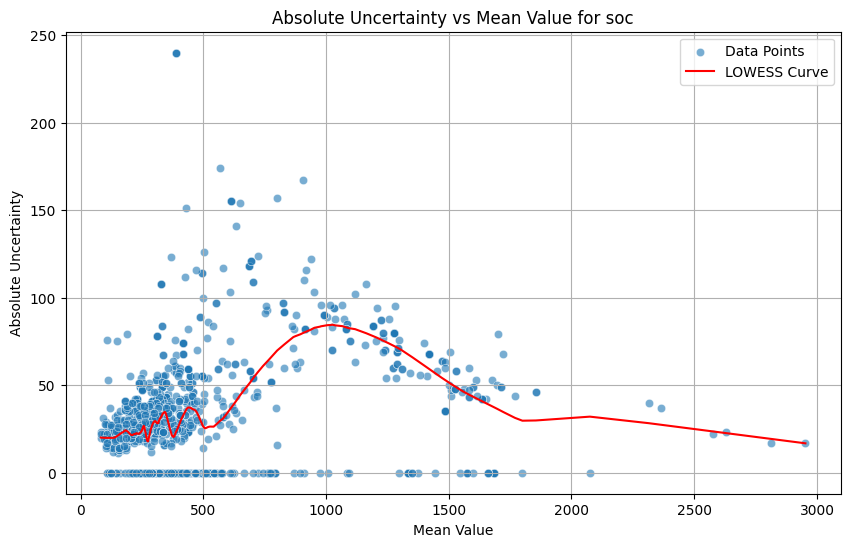

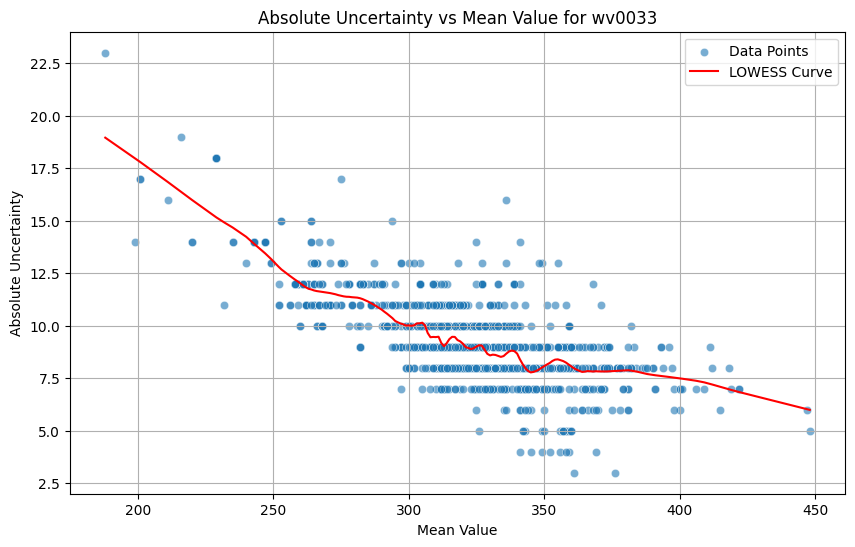

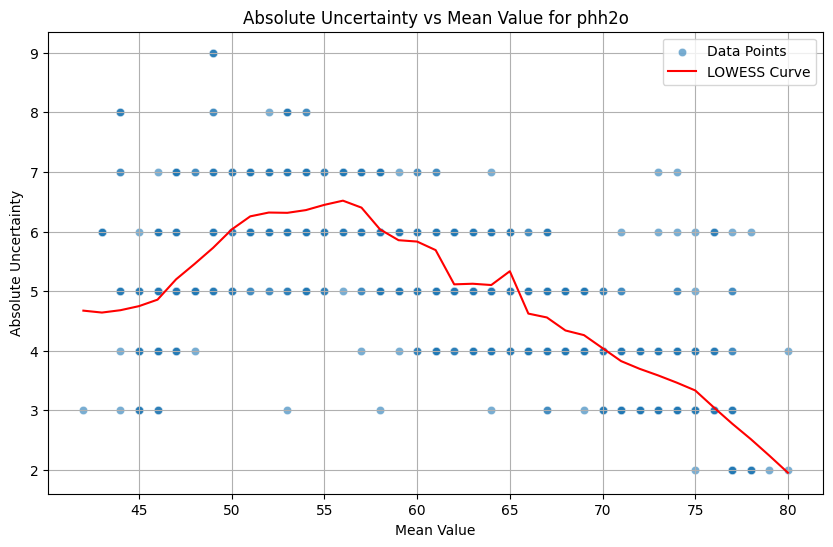

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_relative_uncertainty(df, value):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[f'{value}_mean'], y=df[f'{value}_uncertainty'], alpha=0.6, label='Data Points')
    
    # Fit and plot a LOWESS (Locally Weighted Scatterplot Smoothing) curve
    lowess_curve = lowess(df[f'{value}_uncertainty'], df[f'{value}_mean'], frac=0.1)
    plt.plot(lowess_curve[:, 0], lowess_curve[:, 1], color='red', label='LOWESS Curve')
    
    plt.title(f'Absolute Uncertainty vs Mean Value for {value}')
    plt.xlabel('Mean Value')
    plt.ylabel('Absolute Uncertainty')
    plt.legend()
    plt.grid(True)
    plt.show()

for value in values:
    plot_relative_uncertainty(coordinates, value)

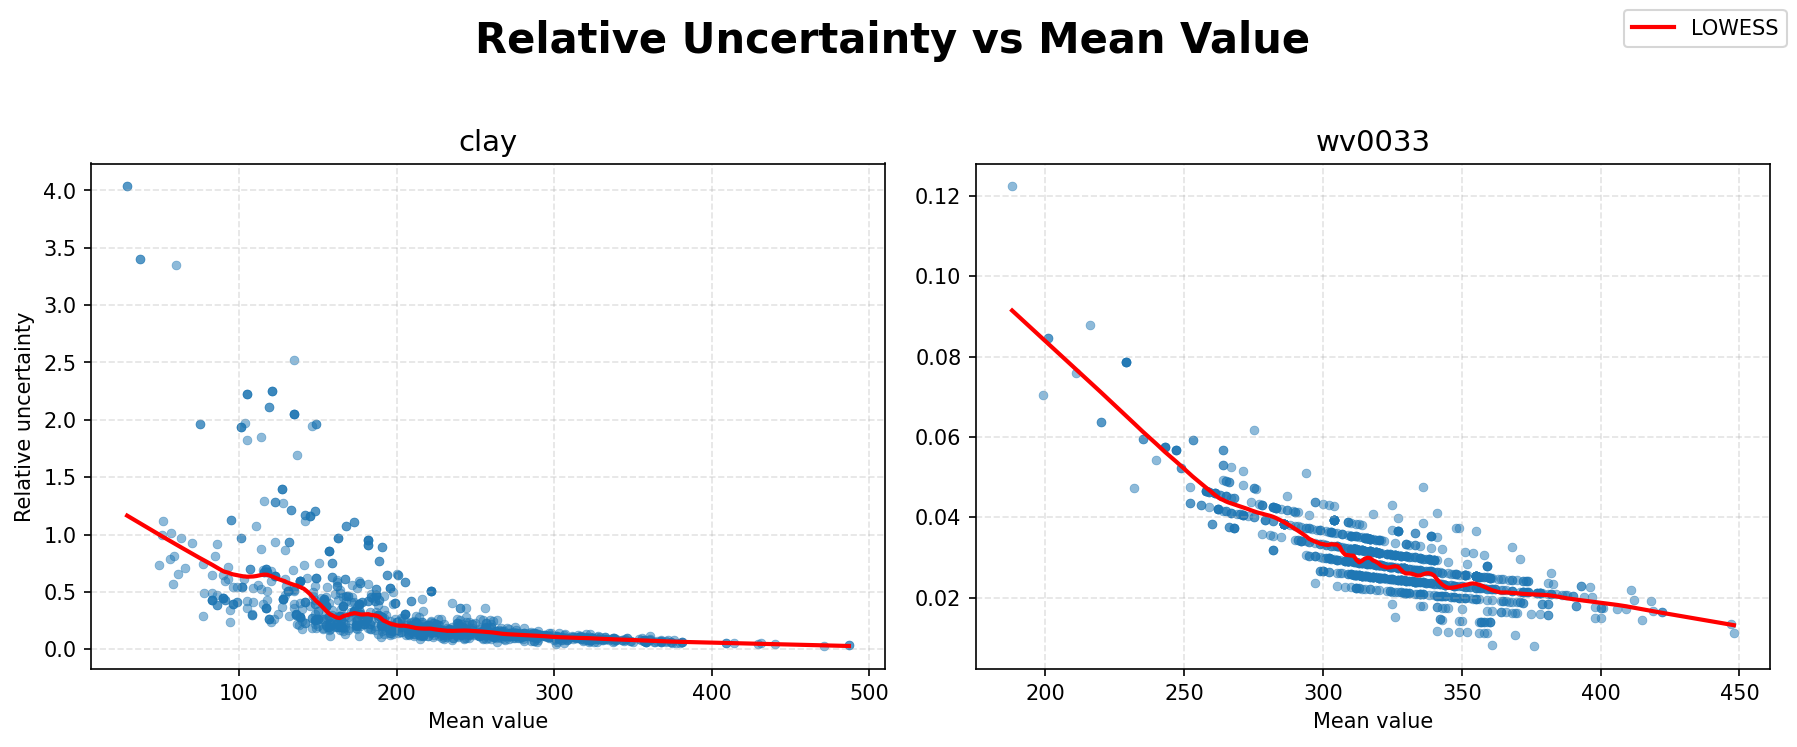

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_relative_uncertainty_side_by_side(df, values, frac=0.1, title_size=28, savepath=None):
    # Independent y-scales for each subplot
    fig, axes = plt.subplots(1, len(values), figsize=(12, 5), dpi=150, sharey=False)
    if len(values) == 1:
        axes = [axes]

    for ax, value in zip(axes, values):
        x = df[f'{value}_mean']
        y = df[f'{value}_relative_uncertainty']

        mask = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
        sns.scatterplot(x=x[mask], y=y[mask], ax=ax, alpha=0.5, s=18, color='tab:blue', edgecolor=None)
        low = lowess(y[mask], x[mask], frac=frac, return_sorted=True)
        ax.plot(low[:, 0], low[:, 1], color='red', lw=2, label='LOWESS')

        ax.set_title(value, fontsize=14)
        ax.set_xlabel('Mean value')
        ax.grid(True, ls='--', alpha=0.35)
        if ax is axes[0]:
            ax.set_ylabel('Relative uncertainty')
        else:
            ax.set_ylabel('')

    fig.suptitle('Relative Uncertainty vs Mean Value', fontsize=title_size, fontweight='bold')
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

values = ['clay', 'wv0033']
plot_relative_uncertainty_side_by_side(coordinates, values, frac=0.1, title_size=20)